In [1]:
import collections, math, os, sys
sys.path.insert(0, '../../../../FISH-annotation/Annotation')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
from sklearn.neighbors import KDTree
import util
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
json_names = ['sz_0.5_snr_1_3_5_7_9_11.json', 
              'sz_0.5_snr_1_3_5_7_9_11_inv.json',
              'sz_1_snr_1_3_5_7_9_11.json', 
              'sz_1_snr_1_3_5_7_9_11_inv.json',
              'sz_1.75_snr_1_3.json', 
              'sz_1.75_snr_1_3_inv.json',
              'sz_1.75_snr_5_7_9_11.json', 
              'sz_1.75_snr_5_7_9_11_inv.json']
cwd = os.getcwd()

# Detection vs. SNR
Average detection vs. SNR. Each marker represents one SNR bin.

In [3]:
snr_list = [3,5,7,9,11]
clustering_params = ['AffinityPropagation', -350]
correctness_threshold = 4
declumping_params = ['KMeans', 2]
height = 300

## spot size = 0.5
original and inverted images

<Figure size 864x504 with 0 Axes>

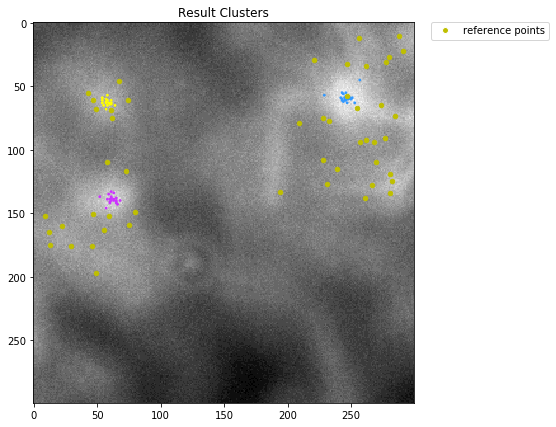

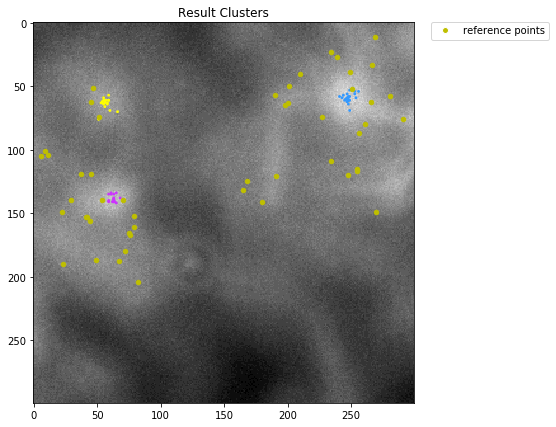

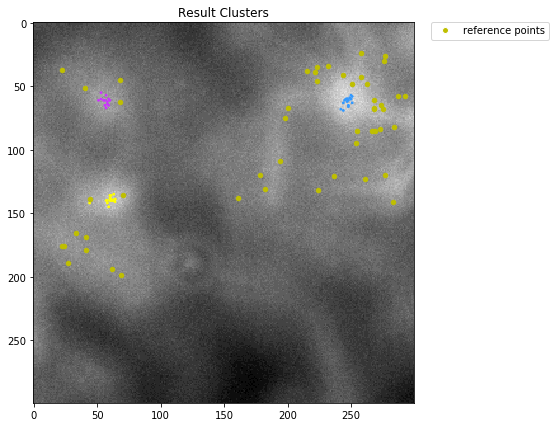

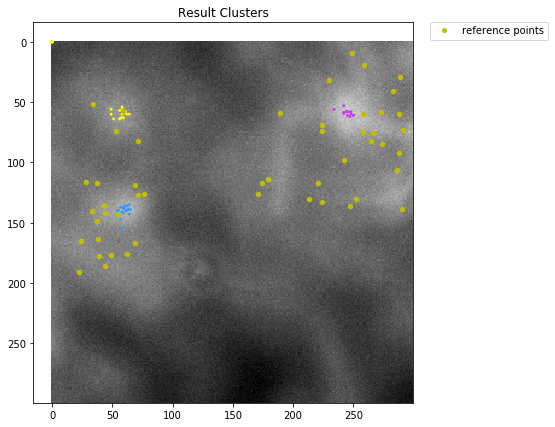

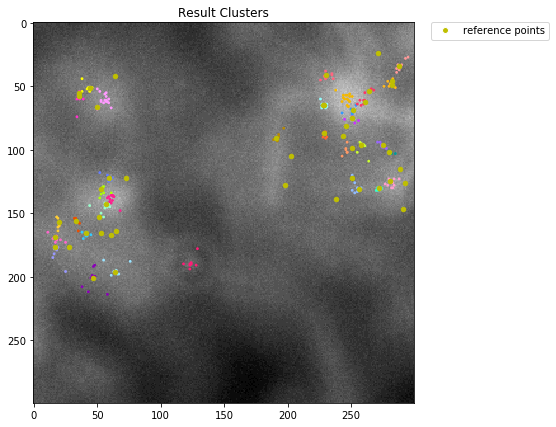

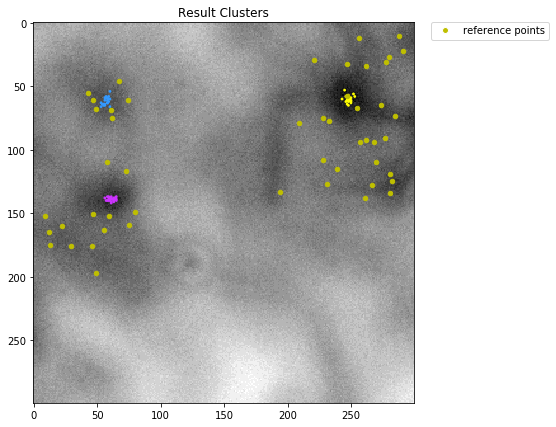

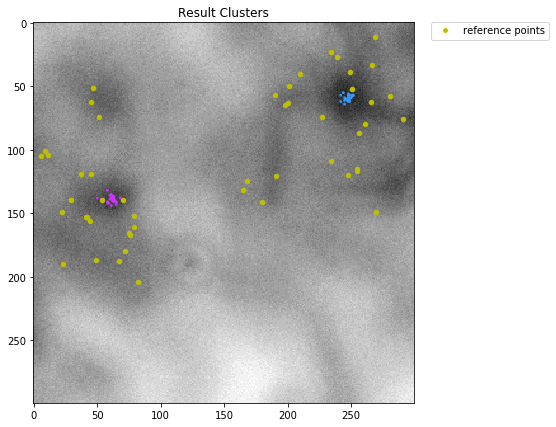

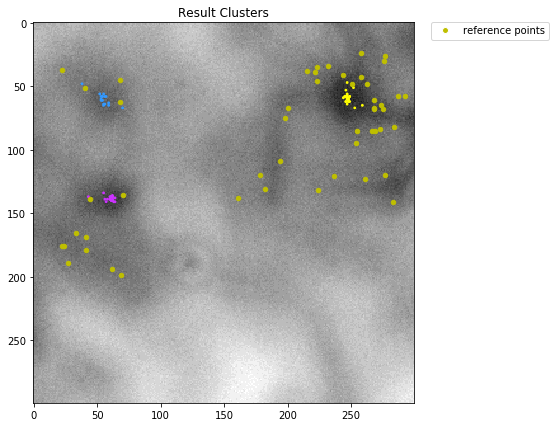

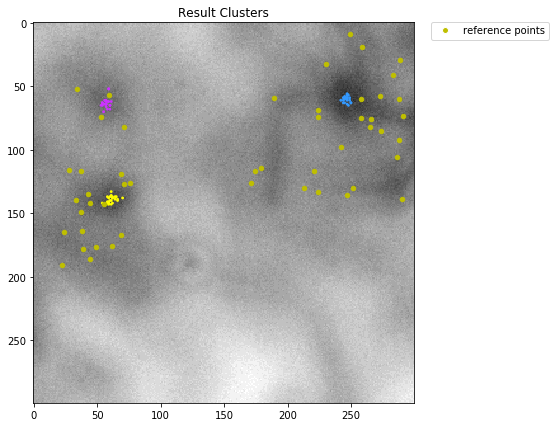

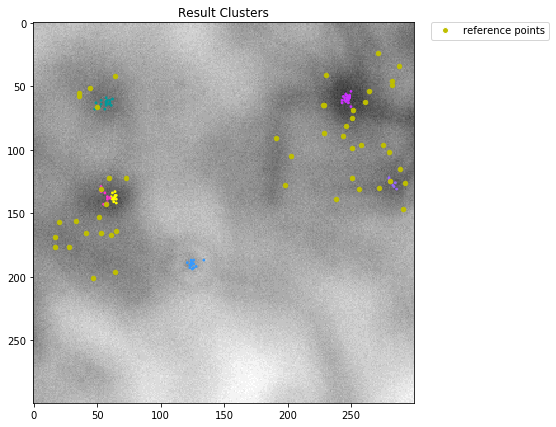

In [4]:
json_paths = [cwd + '/anno/sz_0.5_snr_1_3_5_7_9_11.json',
              cwd + '/anno/sz_0.5_snr_1_3_5_7_9_11_inv.json']

num_spots_detected_list = [0]*len(snr_list)
num_spots_total_list = [0]*len(snr_list)
detection_lists = []

fig = plt.figure(figsize=(12,7))
# for each file
for json_path in json_paths:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        snr = snr_list[index]

        if(json_path == json_paths[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_spot_img.png'
            img_path = cwd + '/spot_images/og/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_spot_img_inv.png'
            img_path = cwd + '/spot_images/inv/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_0.5_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

        util.visualize_clusters(clusters=result_clusters, show_workers=True, img_filepath=img_path, img_height=height, csv_filepath=csv_path, show_ref_points=True, bigger_window_size=False, plot_title='Result Clusters')

        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list[index] += num_total    
            num_spots_detected_list[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list, num_spots_total_list)]
    detection_lists.append(detection_list)


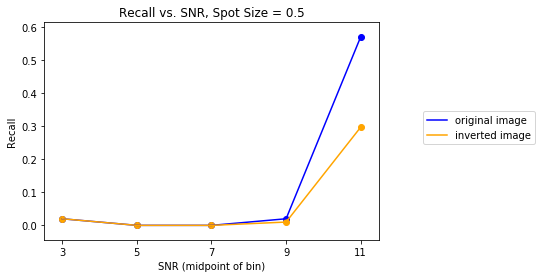

In [5]:
from matplotlib.lines import Line2D

plt.scatter(snr_list, detection_lists[0], color='blue')
plt.plot(snr_list, detection_lists[0], color='blue')
plt.scatter(snr_list, detection_lists[1], color='orange')
plt.plot(snr_list, detection_lists[1], color='orange')

line_1 = Line2D([0],[0], color='blue', label='original image')
line_2 = Line2D([0],[0], color='orange', label='inverted image')
plt.legend(handles=[line_1, line_2], loc=9, bbox_to_anchor=(1.3, 0.615))

plt.xticks(range(3, 12, 2))
plt.xlabel('SNR (midpoint of bin)')
plt.ylabel('Recall')
plt.title('Recall vs. SNR, Spot Size = 0.5')
plt.show()

<Figure size 864x504 with 0 Axes>

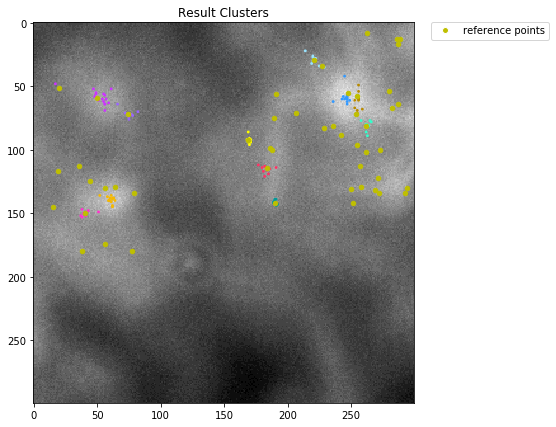

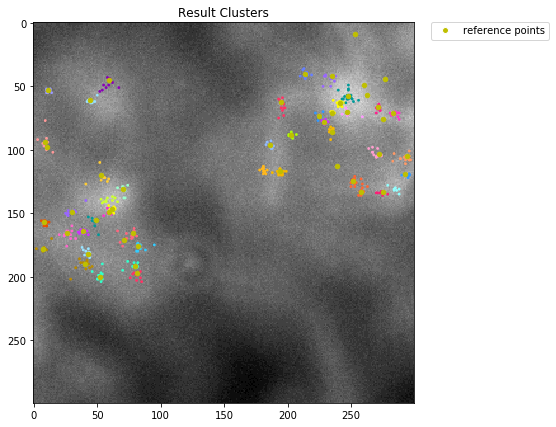

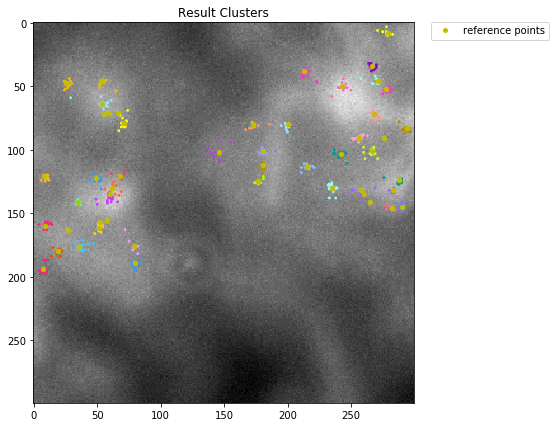

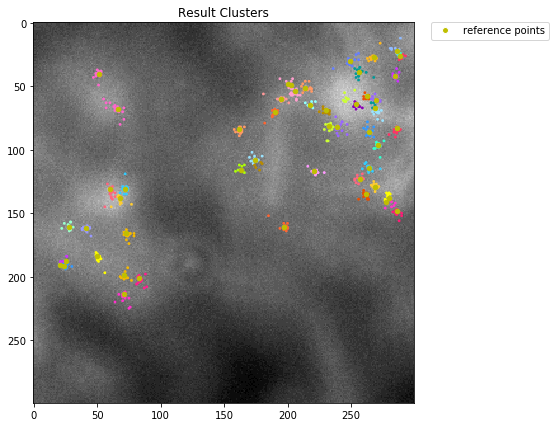

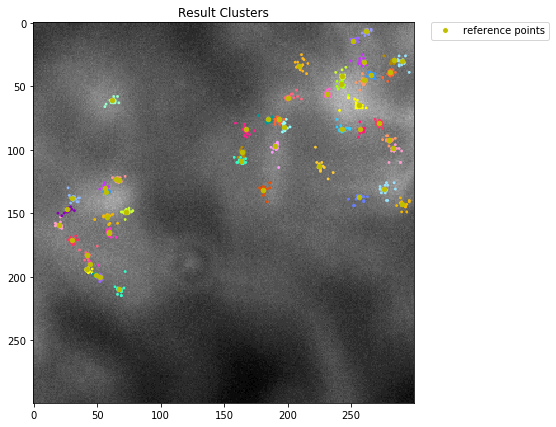

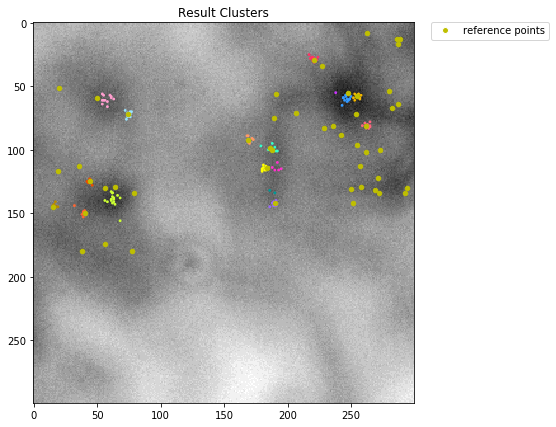

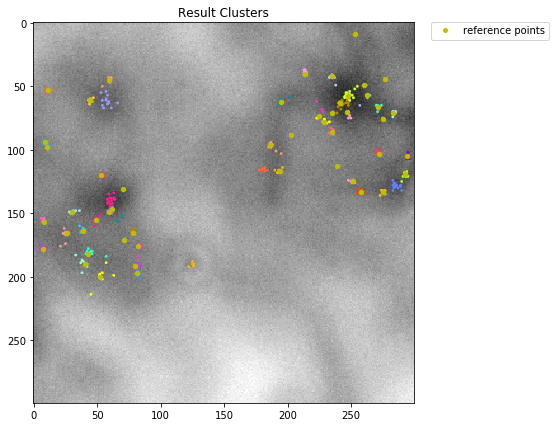

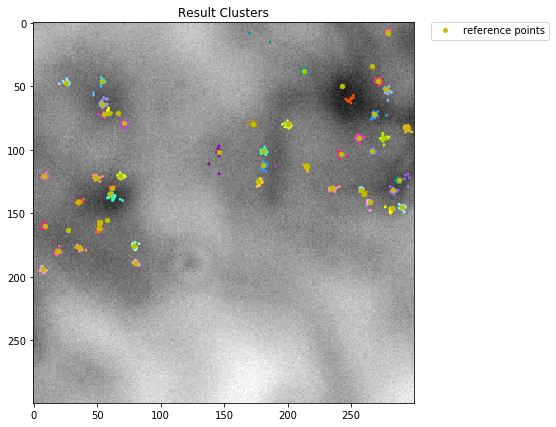

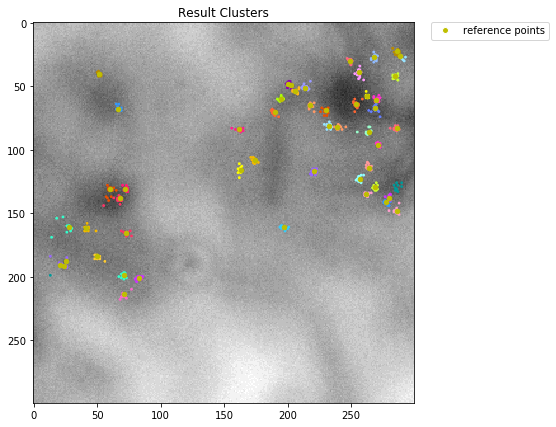

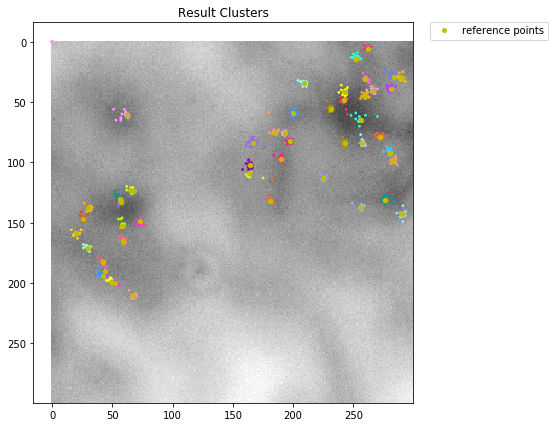

In [6]:
json_paths = [cwd + '/anno/sz_1_snr_1_3_5_7_9_11.json',
              cwd + '/anno/sz_1_snr_1_3_5_7_9_11_inv.json']

num_spots_detected_list = [0]*len(snr_list)
num_spots_total_list = [0]*len(snr_list)
detection_lists = []

fig = plt.figure(figsize=(12,7))
# for each file
for json_path in json_paths:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        snr = snr_list[index]
        
        if(json_path == json_paths[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_spot_img.png'
            img_path = cwd + '/spot_images/og/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_spot_img_inv.png'
            img_path = cwd + '/spot_images/inv/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_spot_sigma_1_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

        util.visualize_clusters(clusters=result_clusters, show_workers=True, img_filepath=img_path, img_height=height, csv_filepath=csv_path, show_ref_points=True, bigger_window_size=False, plot_title='Result Clusters')

        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list[index] += num_total    
            num_spots_detected_list[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list, num_spots_total_list)]
    detection_lists.append(detection_list)


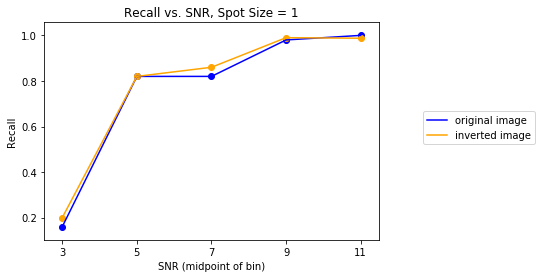

In [7]:
from matplotlib.lines import Line2D

plt.scatter(snr_list, detection_lists[0], color='blue')
plt.plot(snr_list, detection_lists[0], color='blue')
plt.scatter(snr_list, detection_lists[1], color='orange')
plt.plot(snr_list, detection_lists[1], color='orange')


line_1 = Line2D([0],[0], color='blue', label='original image')
line_2 = Line2D([0],[0], color='orange', label='inverted image')
plt.legend(handles=[line_1, line_2], loc=9, bbox_to_anchor=(1.3, 0.615))

plt.xticks(range(3, 12, 2))
plt.xlabel('SNR (midpoint of bin)')
plt.ylabel('Recall')
plt.title('Recall vs. SNR, Spot Size = 1')
plt.show()

## spot size = 1.75
original and inverted images

<Figure size 864x504 with 0 Axes>

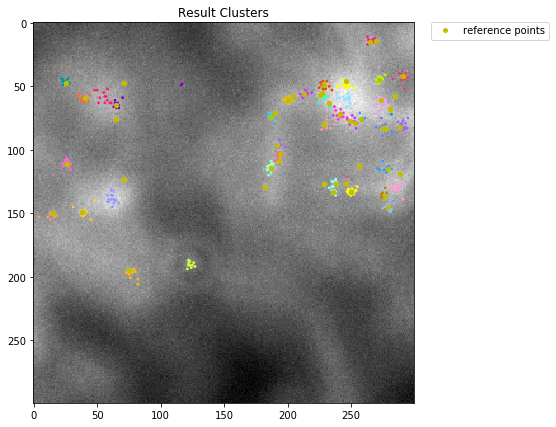

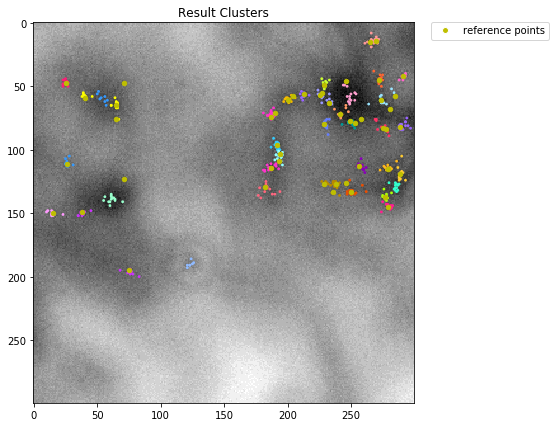

[[0.7380952380952381], [0.7380952380952381]]


In [8]:
json_paths_1 = [cwd + '/anno/sz_1.75_snr_1_3.json',
               cwd + '/anno/sz_1.75_snr_1_3_inv.json']

num_spots_detected_list_1 = [0]
num_spots_total_list_1 = [0]
detection_lists_1 = []
snr_list = [3]

fig = plt.figure(figsize=(12,7))
# for each file
for json_path in json_paths_1:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        snr = snr_list[index]

        if(json_path == json_paths_1[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img.png'
            img_path = cwd + '/spot_images/og/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img_inv.png'
            img_path = cwd + '/spot_images/inv/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

        util.visualize_clusters(clusters=result_clusters, show_workers=True, img_filepath=img_path, img_height=height, csv_filepath=csv_path, show_ref_points=True, bigger_window_size=False, plot_title='Result Clusters')

        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list_1[index] += num_total    
            num_spots_detected_list_1[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list_1, num_spots_total_list_1)]
    detection_lists_1.append(detection_list)
        


print(detection_lists_1)



<Figure size 864x504 with 0 Axes>

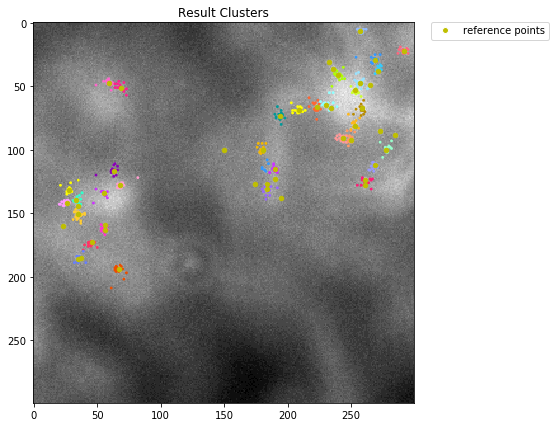

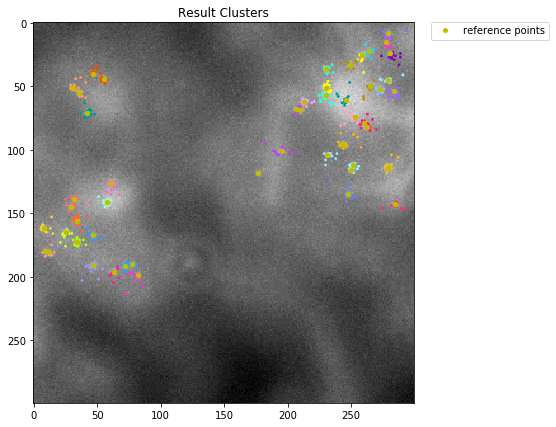

IndexError: list index out of range

In [9]:
json_paths_2 = [cwd + '/anno/sz_1.75_snr_5_7_9_11.json', 
               cwd + '/anno/sz_1.75_snr_5_7_9_11_inv.json']

num_spots_detected_list_2 = [0]*len(snr_list)
num_spots_total_list_2 = [0]*len(snr_list)
detection_lists_2 = []
snr_list = [5, 7, 9, 11]    

fig = plt.figure(figsize=(12,7))
# for each file
for json_path in json_paths_2:
    detection_list = []
    # for each image
    for index in range(len(snr_list)):
        snr = snr_list[index]

        if(json_path == json_paths_2[0]):
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img.png'
            img_path = cwd + '/spot_images/og/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        else:
            img_name = 'snr_' + str(snr) + '_1_numspots_50_spot_img_inv.png'
            img_path = cwd + '/spot_images/inv/' + img_name
            csv_path = cwd + '/spot_data/' + 'snr_' + str(snr) + '_1_numspots_50_coord_snr_list.csv'
        
        """ Get cluster centroids """
        qa = QuantiusAnnotation(json_path, img_name)
        anno_all = qa.df()
        sa = SpotAnnotationAnalysis(qa)

        clusters = sa.get_clusters(anno_all, clustering_params)
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

        """ Count up num_spots_detected, num_spots_total at each SNR """
        result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
        result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

        util.visualize_clusters(clusters=result_clusters, show_workers=True, img_filepath=img_path, img_height=height, csv_filepath=csv_path, show_ref_points=True, bigger_window_size=False, plot_title='Result Clusters')

        ref_df = pd.read_csv(csv_path)
        ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
        ref_points_snr = ref_df.loc[:, ['snr']].as_matrix()

        # for each bin
        for bin_midpoint in snr_list:
            num_total = 0
            num_detected = 0

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_points_snr):
                ref_snr = ref_snr[0]

                # if the spot's is in the SNR bin
                if (ref_snr > bin_midpoint-1) and (ref_snr <= bin_midpoint+1):
                    num_total += 1
                    dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                    if dist[0][0] <= correctness_threshold:
                        num_detected += 1
            num_spots_total_list_2[index] += num_total    
            num_spots_detected_list_2[index] += num_detected

    detection_list = [d/t for d, t in zip(num_spots_detected_list_2, num_spots_total_list_2)]
    detection_lists_2.append(detection_list)

In [ ]:
detection_list_og = detection_lists_1[0] + detection_lists_2[0]
detection_list_inv = detection_lists_1[1] + detection_lists_2[1]
detection_lists = [detection_list_og, detection_list_inv]
snr_list = [3,5,7,9,11]

In [ ]:
from matplotlib.lines import Line2D

plt.scatter(snr_list, detection_lists[0], color='blue')
plt.plot(snr_list, detection_lists[0], color='blue')
plt.scatter(snr_list, detection_lists[1], color='orange')
plt.plot(snr_list, detection_lists[1], color='orange')


line_1 = Line2D([0],[0], color='blue', label='original image')
line_2 = Line2D([0],[0], color='orange', label='inverted image')
plt.legend(handles=[line_1, line_2], loc=9, bbox_to_anchor=(1.3, 0.615))

plt.xticks(range(3, 12, 2))
plt.xlabel('SNR (midpoint of bin)')
plt.ylabel('Recall')
plt.title('Recall vs. SNR, Spot Size = 1.75')
plt.show()